## Softmax回归（多分类）实现

### MNIST数据集的提取

In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import My_utils

My_utils.use_svg_display()

In [2]:
trans=transforms.ToTensor()#将image或ndarray转为tensor
train_set=torchvision.datasets.FashionMNIST(root='./data',train=True,transform=trans,download=True)
test_set=torchvision.datasets.FashionMNIST(root='./data',train=False,transform=trans,download=True)

### Fashion-MNIST数据集的处理

In [3]:
def get_fashion_mnist_labels(labels):#索引和label的转换，MNIST数据集是数值的标号
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]#输入的labels是一串数字，表示需要展示的图片的labels，后续i作为该labels的索引

def show_image(imgs,row_num,col_num,titles=None,scale=1.5):
    figsize=(col_num*scale,row_num*scale)
    _,axes=plt.subplots(row_num,col_num,figsize=figsize)
    axes=axes.flatten()
    for i,(ax,img) in enumerate(zip(axes,imgs)):#i是图片的索引
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)#将坐标轴设为不可见
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

### 开始Softmax的实现

#### 准备组件

In [4]:
batch_size=256
train_iter,test_iter=My_utils.load_data_from_fashion_MNIST(batch_size)
#图片是28*28的，也就是784个像素，因此这个网络是一个784->10的网络
num_inputs=784
num_outputs=10
W=torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)#784行，10列
b=torch.zeros(num_outputs,requires_grad=True)

def softmax(X):#对应sigmoid函数，是一个用于映射的函数
    X_exp=torch.exp(X)
    partition=X_exp.sum(1,keepdim=True)#保留列的求和
    return X_exp/partition

def net(X):
    return softmax(torch.matmul(X.reshape(-1,W.shape[0]),W)+b)#shape[0]返回的是他第0维的形状，也就是他的行数；  将X转化为一个256*784的张量

def cross_entropy(y_hat,y):#损失函数
    return -torch.log(y_hat[range(len(y_hat)),y])

def count_accurate(y_hat,y):
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat=y_hat.argmax(axis=1)
    correct_count=0
    for i in range(len(y_hat)):
        if y_hat[i].type(y.dtype)==y[i]:
            correct_count+=1
    return float(correct_count)

def calc_accuracy(net,data_iter):
    if isinstance(net,torch.nn.Module):
        net.eval()#进入评估模式
    metric=My_utils.Accumulator(2)
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(count_accurate(net(X),y),y.numel())
    return  metric[0]/metric[1]

#### 开始训练

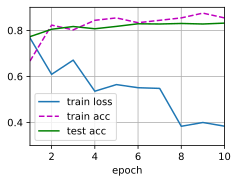

In [5]:
lr=0.1
def updater(batch_size):#定义优化器，选择梯度下降来进行优化
    return My_utils.sgd([W,b],learning_rate=lr,batch_size=batch_size)

def train_epoch(train_iter,net,loss,updater):
    if isinstance(net,torch.nn.Module):
        net.train()
    metric=My_utils.Accumulator(3)
    for X,y in train_iter:
        y_hat=net(X)
        l=loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            #用pytorch内置的优化器来优化
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])#第0维的数量就是batch_size
    metric.add(l.sum(),count_accurate(y_hat,y),y.numel())
    return metric[0]/metric[2],metric[1]/metric[2]

def train(train_epochs,test_iter,train_iter,net,loss,updater):
    animator=My_utils.Animator(xlabel='epoch', xlim=[1, train_epochs], ylim=[0.3, 0.9],legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(train_epochs):
        train_metrics=train_epoch(train_iter,net,loss,updater)
        test_acc=calc_accuracy(net,test_iter)
        animator.add(epoch+1,train_metrics+(test_acc,))
    train_loss,train_acc=train_metrics

epoch_num=10
train(epoch_num,test_iter,train_iter,net,cross_entropy,updater)

### 预测

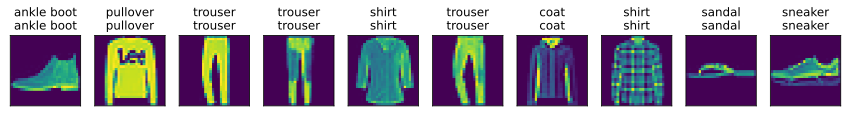

In [6]:
def predict(net,test_iter,n=10):
    for X,y in test_iter:
        break
    trues=get_fashion_mnist_labels(y)
    preds=get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles=[true +'\n' + pred for true,pred in zip(trues,preds)]
    show_image(X[0:n].reshape((n,28,28)),1,n,titles=titles)
predict(net,test_iter)